In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T
from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task="node"):
        super(GNNStack,self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim,hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim,hidden_dim))
        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim,hidden_dim),nn.Dropout(0.25),
            nn.Linear(hidden_dim,output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')
        
        self.dropout = 0.25
        self.num_layers = 3
        
    def build_conv_model(self,input_dim,hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim,hidden_dim)
            #return CustomCov(input_dim,hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim), 
                                                nn.ReLU(), nn.Linear(hidden_dim,hidden_dim)))
    
    def forward(self,data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)
        
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p = self.dropout, training = self.training)
        
        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)
        
        x = self.post_mp(x)
        
        return emb, F.log_softmax(x, dim = 1)
    
    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [3]:
class CustomCov(pyg_nn.MessagePassing):
    def __init__(slef, in_channels, out_channels):
        super(CustomCov, self).__init__(aggr='add')    #"Add" aggretation.
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin_self = nn.Linear(in_channels, out_channels)
    def forward(self,x,edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2,E]
        
        # Add self-loops to Adjacency matrix.
        #edge_index, _ = pyg_utils.add_self_loops(edge_index)
        edge_index, _ = pyg_utils.remove_self_loops(edge_index)
        
        # Transform node feature matrix.
        self_x = self.lin_self(x)
        # x = self.lin(x)
        
        return self_x + self.propagate(edge_index, size=(x.size(0),x.size(0)), x = self.lin(x))
    
    def message(self, x_i, x_j, edge_index, size):
        # The message function is called inside of the **propagate**
        # compute message
        # x_j has shape [E, out_channels]
        # It can take all the parameters that the **propagate** takes
        
        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype = x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row]*deg_inv_sqrt[col]
        
        #return norm.view(-1,1)*x_j
        return x_j
        
    def update(self, aggr_out):
        # One can do normalization (l2, l1) or mlp after message passing
        # for instance => F.normalize(aggr_out, p=2, dim=-1)
        # aggr_out has shape [N, out_channels]
        return aggr_out
    
    

# Training loop

In [4]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size*0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size*0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task = task)
    opt = optim.Adam(model.parameters(), lr = 0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                # mask for separating the training graphs and validation graphs
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item()* batch.num_graphs
        
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)
        
        if epoch % 10 == 0:
            test_acc = test(test_loader,model)
            print("Epoch{}. Loss: {:.4f}. Test accuracy: {:.4f}".format(epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)
            
    return model

In [5]:
def test(loader, model, is_validation = False):
    model.eval()
    
    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y
            
        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct +=pred.eq(label).sum().item()
        
    if model.task == 'graph':
        total = len(loader.dataset)
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct/total
        

In [ ]:
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format("./log"))
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
        "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [6]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = TUDataset(root='/tmp/IMDB-BINARY',name='IMDB-BINARY')
dataset = dataset.shuffle()

task = 'graph'

model = train(dataset,task,writer)

Epoch0. Loss: 1.8841. Test accuracy: 0.4200
Epoch10. Loss: 0.6264. Test accuracy: 0.6100
Epoch20. Loss: 0.5910. Test accuracy: 0.6150
Epoch30. Loss: 0.5902. Test accuracy: 0.6600
Epoch40. Loss: 0.5944. Test accuracy: 0.6300
Epoch50. Loss: 0.5833. Test accuracy: 0.6100
Epoch60. Loss: 0.5662. Test accuracy: 0.6350
Epoch70. Loss: 0.5644. Test accuracy: 0.6350
Epoch80. Loss: 0.5519. Test accuracy: 0.6400
Epoch90. Loss: 0.5731. Test accuracy: 0.6300
Epoch100. Loss: 0.5711. Test accuracy: 0.6700
Epoch110. Loss: 0.5773. Test accuracy: 0.6500
Epoch120. Loss: 0.5554. Test accuracy: 0.6450
Epoch130. Loss: 0.5622. Test accuracy: 0.6650
Epoch140. Loss: 0.5556. Test accuracy: 0.6650
Epoch150. Loss: 0.5606. Test accuracy: 0.6650
Epoch160. Loss: 0.5678. Test accuracy: 0.6700
Epoch170. Loss: 0.5571. Test accuracy: 0.6800
Epoch180. Loss: 0.5601. Test accuracy: 0.6700
Epoch190. Loss: 0.5539. Test accuracy: 0.6650


In [7]:
writer = SummaryWriter("./log/"+ datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/citeseer', name='citeseer')
task = 'node'

model = train(dataset,task, writer)

Epoch0. Loss: 1.7992. Test accuracy: 0.0790
Epoch10. Loss: 0.5119. Test accuracy: 0.6540
Epoch20. Loss: 0.1444. Test accuracy: 0.6120
Epoch30. Loss: 0.0623. Test accuracy: 0.6210
Epoch40. Loss: 0.0254. Test accuracy: 0.6370
Epoch50. Loss: 0.0207. Test accuracy: 0.6240
Epoch60. Loss: 0.0361. Test accuracy: 0.6280
Epoch70. Loss: 0.0019. Test accuracy: 0.6310
Epoch80. Loss: 0.0016. Test accuracy: 0.6110
Epoch90. Loss: 0.0736. Test accuracy: 0.6220
Epoch100. Loss: 0.0247. Test accuracy: 0.6210
Epoch110. Loss: 0.0081. Test accuracy: 0.6390
Epoch120. Loss: 0.0036. Test accuracy: 0.6240
Epoch130. Loss: 0.0002. Test accuracy: 0.6190
Epoch140. Loss: 0.0147. Test accuracy: 0.6140
Epoch150. Loss: 0.0026. Test accuracy: 0.6210
Epoch160. Loss: 0.0091. Test accuracy: 0.5750
Epoch170. Loss: 0.0230. Test accuracy: 0.6120
Epoch180. Loss: 0.0024. Test accuracy: 0.5900
Epoch190. Loss: 0.0089. Test accuracy: 0.6190


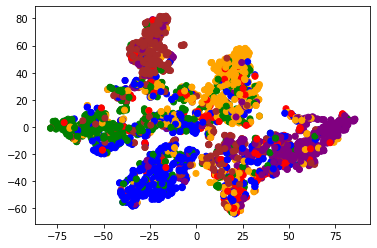

In [8]:
# visualization
color_list = ["red", "orange", "green", "blue", "purple", "brown"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim = 0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color = colors)

# Learning unsupervised embedding with graph autoencoders

In [12]:
# Encoder is 2 Conv layers and decoder is just a dot product
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2*out_channels, cached = True) 
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached = True)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)
    
def train(epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()

    writer.add_scalar("loss", loss.item(), epoch)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z,pos_edge_index,neg_edge_index)

writer = SummaryWriter("./log/"+datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid("/tmp/citeseer","Citeseer",T.NormalizeFeatures())
data = dataset[0]

channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("CUDA availability:", torch.cuda.is_available())

# encoder: written by us; decoder: default (inner product)
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labbels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = model.split_edges(data)
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for epoch in range(1,201):
    train(epoch)
    auc , ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    writer.add_scalar("AUC", auc, epoch)
    writer.add_scalar("AP", ap, epoch)
    if epoch % 10 == 0:
        print('Epoch:{:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

    

CUDA availability: False
Epoch:010, AUC: 0.6571, AP: 0.7353
Epoch:020, AUC: 0.7872, AP: 0.8045
Epoch:030, AUC: 0.7987, AP: 0.8162
Epoch:040, AUC: 0.8150, AP: 0.8253
Epoch:050, AUC: 0.8446, AP: 0.8466
Epoch:060, AUC: 0.8451, AP: 0.8523
Epoch:070, AUC: 0.8479, AP: 0.8554
Epoch:080, AUC: 0.8582, AP: 0.8651
Epoch:090, AUC: 0.8774, AP: 0.8852
Epoch:100, AUC: 0.8771, AP: 0.8866
Epoch:110, AUC: 0.8720, AP: 0.8821
Epoch:120, AUC: 0.8686, AP: 0.8791
Epoch:130, AUC: 0.8669, AP: 0.8762
Epoch:140, AUC: 0.8665, AP: 0.8755
Epoch:150, AUC: 0.8662, AP: 0.8708
Epoch:160, AUC: 0.8653, AP: 0.8723
Epoch:170, AUC: 0.8621, AP: 0.8729
Epoch:180, AUC: 0.8616, AP: 0.8745
Epoch:190, AUC: 0.8605, AP: 0.8735
Epoch:200, AUC: 0.8585, AP: 0.8723


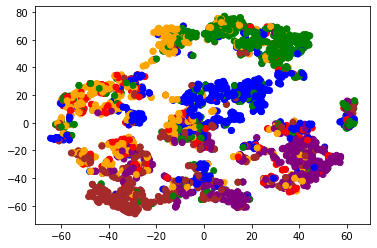

In [14]:
model.eval()
z = model.encode(x, train_pos_edge_index)
colors = [color_list[y] for y in labbels]

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))
plt.scatter(xs, ys, color = colors)
plt.show()